Bonjour!

В домашнем задании Вам предстоит построить несколько моделей машинного обучения, а также ответить на вопросы, эквивалентные интервью на Data Scientist/Machine Learning Engineer и подобные им позиции.

**Мягкий дедлайн :** 18 июня 23-59 с возможностью "бесплатно" вносить правки в течение последующих 3-х дней с момента проверки ДЗ мной,

**Жесткий дедлайн :** 25 июня 23-59 с потерей 50% баллов

**Задача 1** **(40 баллов)**

*Построить модели машинного обучения для задачи классификации, а именно: k-ближайших соседей, SVM, метод парзеновского окна, персептрон.*

Можете выбирать любой датасет для работы, например:

Spambase Data Set : https://archive.ics.uci.edu/ml/datasets/Spambase

Breast Cancer Data Set : https://archive.ics.uci.edu/ml/datasets/breast+cancer

Wine Data Set : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine

Найти датасет по душе можно в UCI Repository (первые две ссылки).

Четких требований по построению модели нет, хочется видеть структуру, последовательность действий и *обязательно анализ*: что получилось, что не очень, что ожидали увидеть в результате, какой получился результат и какие выводы по модели Вы можете сделать, размышления о том, как можно было бы улучшить модель для более точных показателей метрик.

В качестве метрик можете брать любые метрики, которые мы проходили, *желательно опробовать на одной модели порядка двух-трех разных метрик*, чтобы можно было проводить некоторое сравнение.

**Задача 1**

**подготовка и анализ данных (Wine data set)**

In [ ]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from zipfile import ZipFile
from scipy.stats import pearsonr
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

<Axes: >

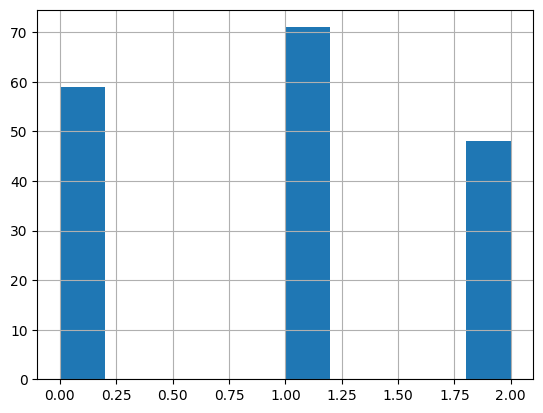

In [ ]:
data_wine = load_wine()
df_wine = pd.DataFrame(data=data_wine.data, columns=data_wine.feature_names)
df_wine['target'] = data_wine.target
df_wine.target.hist()

Из распределения видно, что данные не сбалансированы

<Axes: xlabel='alcohol', ylabel='proline'>

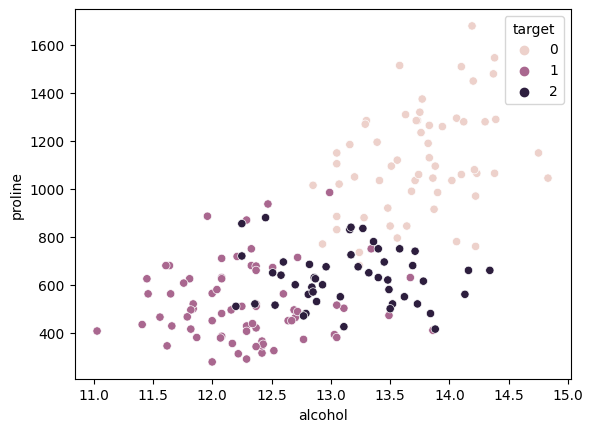

In [ ]:
sns.scatterplot(x=df_wine.alcohol, y=df_wine.proline, hue=df_wine.target)

<Axes: xlabel='flavanoids', ylabel='proline'>

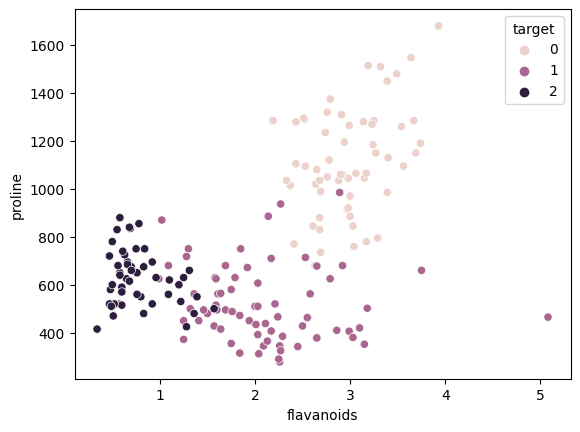

In [ ]:
sns.scatterplot(x=df_wine.flavanoids, y=df_wine.proline, hue=df_wine.target)

<Axes: xlabel='flavanoids', ylabel='alcohol'>

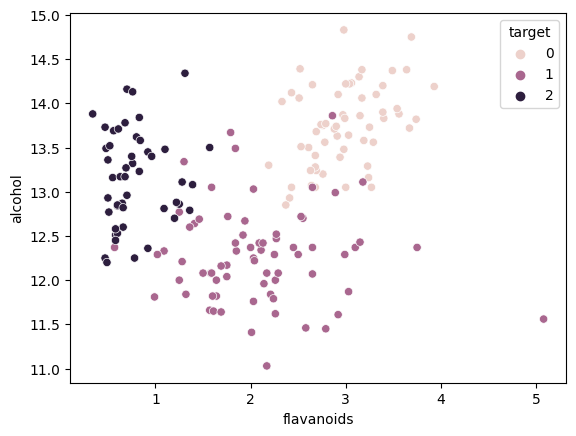

In [ ]:
sns.scatterplot(x=df_wine.flavanoids, y=df_wine.alcohol, hue=df_wine.target)

<Axes: xlabel='color_intensity', ylabel='proline'>

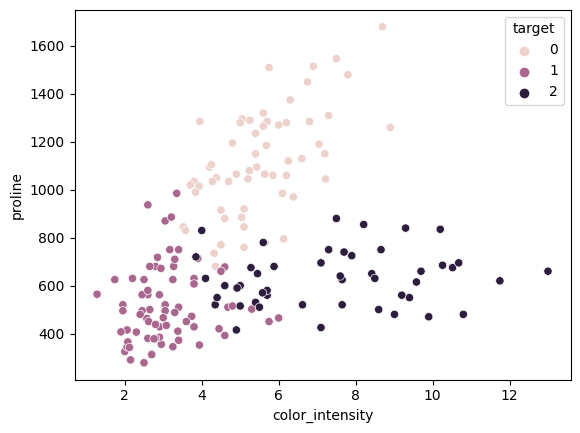

In [ ]:
sns.scatterplot(x=df_wine.color_intensity, y=df_wine.proline, hue=df_wine.target)

Так как данные не сбалансированы, выберем следующие метрики: Balanced Accuracy и Macro f1 score

Исследуем признаки на линейную зависимость:

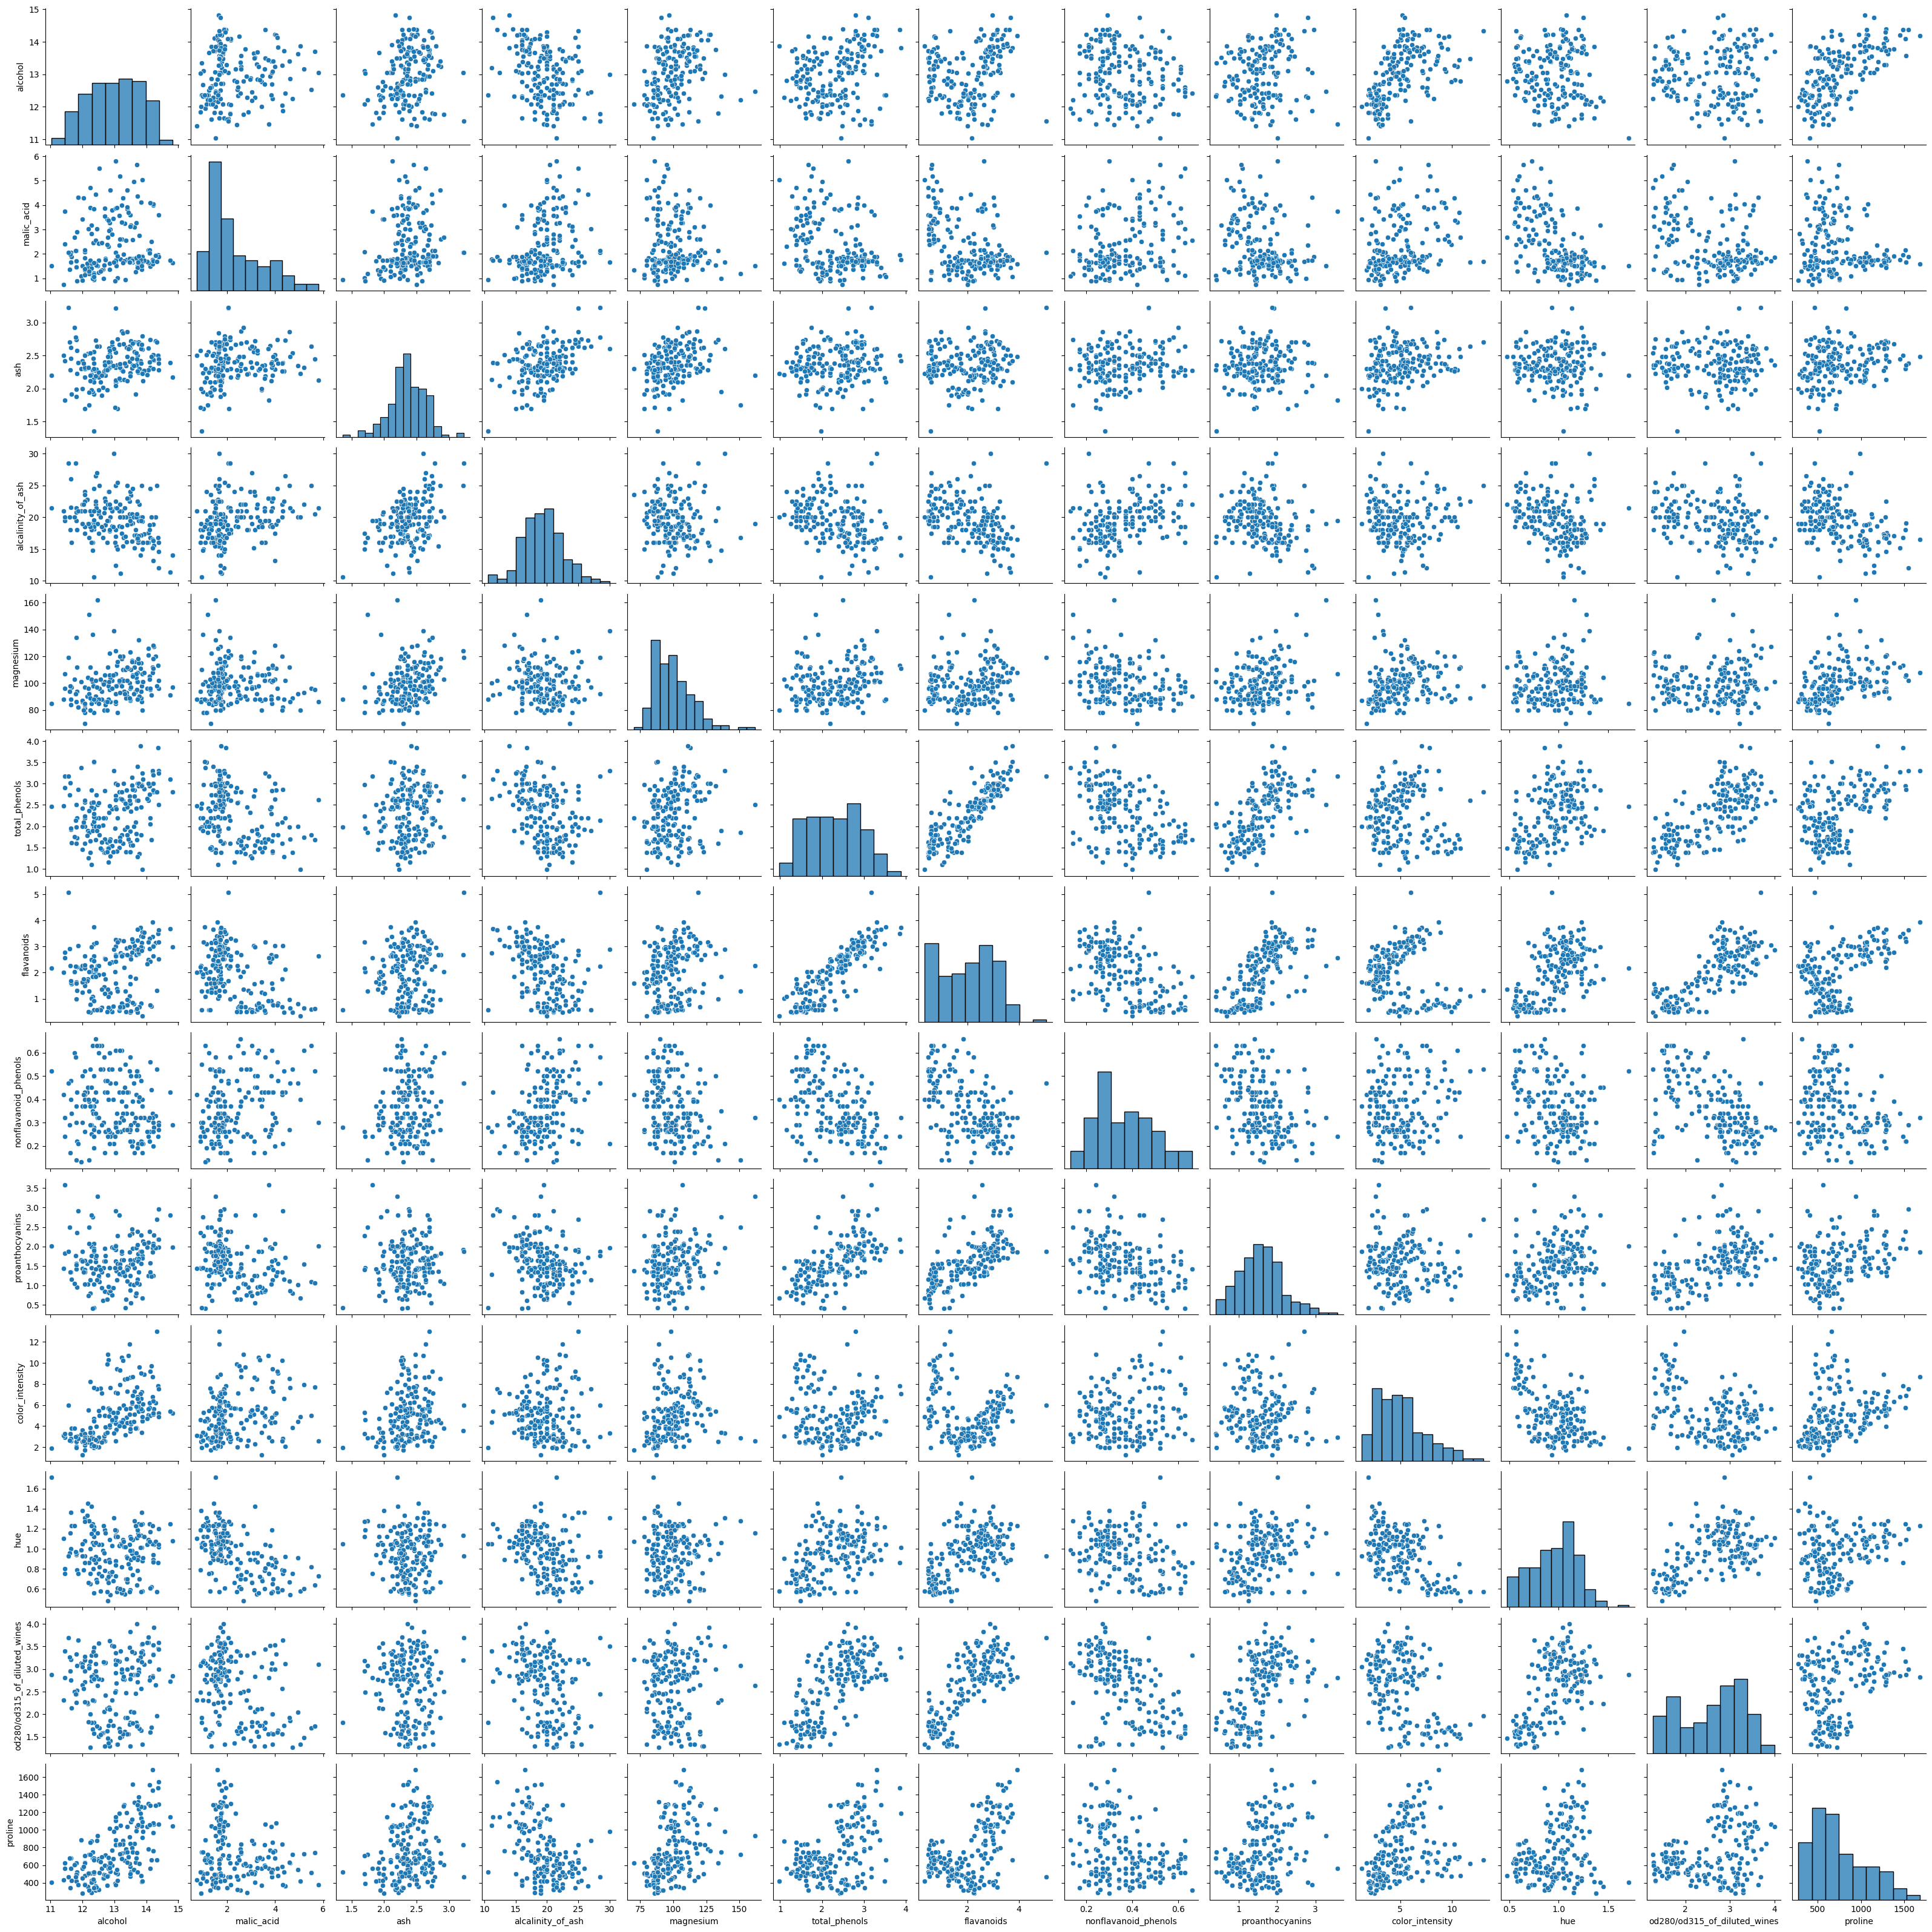

In [ ]:
X = df_wine.drop('target', axis=1)
sns.pairplot(X)

Между подозрительными на зависимость признаками посчитаем коэффициент пирсона:

In [ ]:
pearsonr(X['od280/od315_of_diluted_wines'], X['flavanoids']), pearsonr(X['total_phenols'], X['flavanoids'])

(PearsonRResult(statistic=0.7871939018669515, pvalue=8.604101857575826e-39),
 PearsonRResult(statistic=0.8645635000951147, pvalue=1.755838952586819e-54))

In [ ]:
pearsonr(X['proanthocyanins'], X['flavanoids']), pearsonr(X['hue'], X['flavanoids'])

(PearsonRResult(statistic=0.6526917686075154, pvalue=5.551895711508112e-23),
 PearsonRResult(statistic=0.5434785664899896, pvalue=4.553875646202151e-15))

Удалим из каждой пары по одному линейно зависимому признаку:

In [ ]:
X = X.drop(['od280/od315_of_diluted_wines', 'total_phenols', 'proanthocyanins', 'hue'], axis=1)

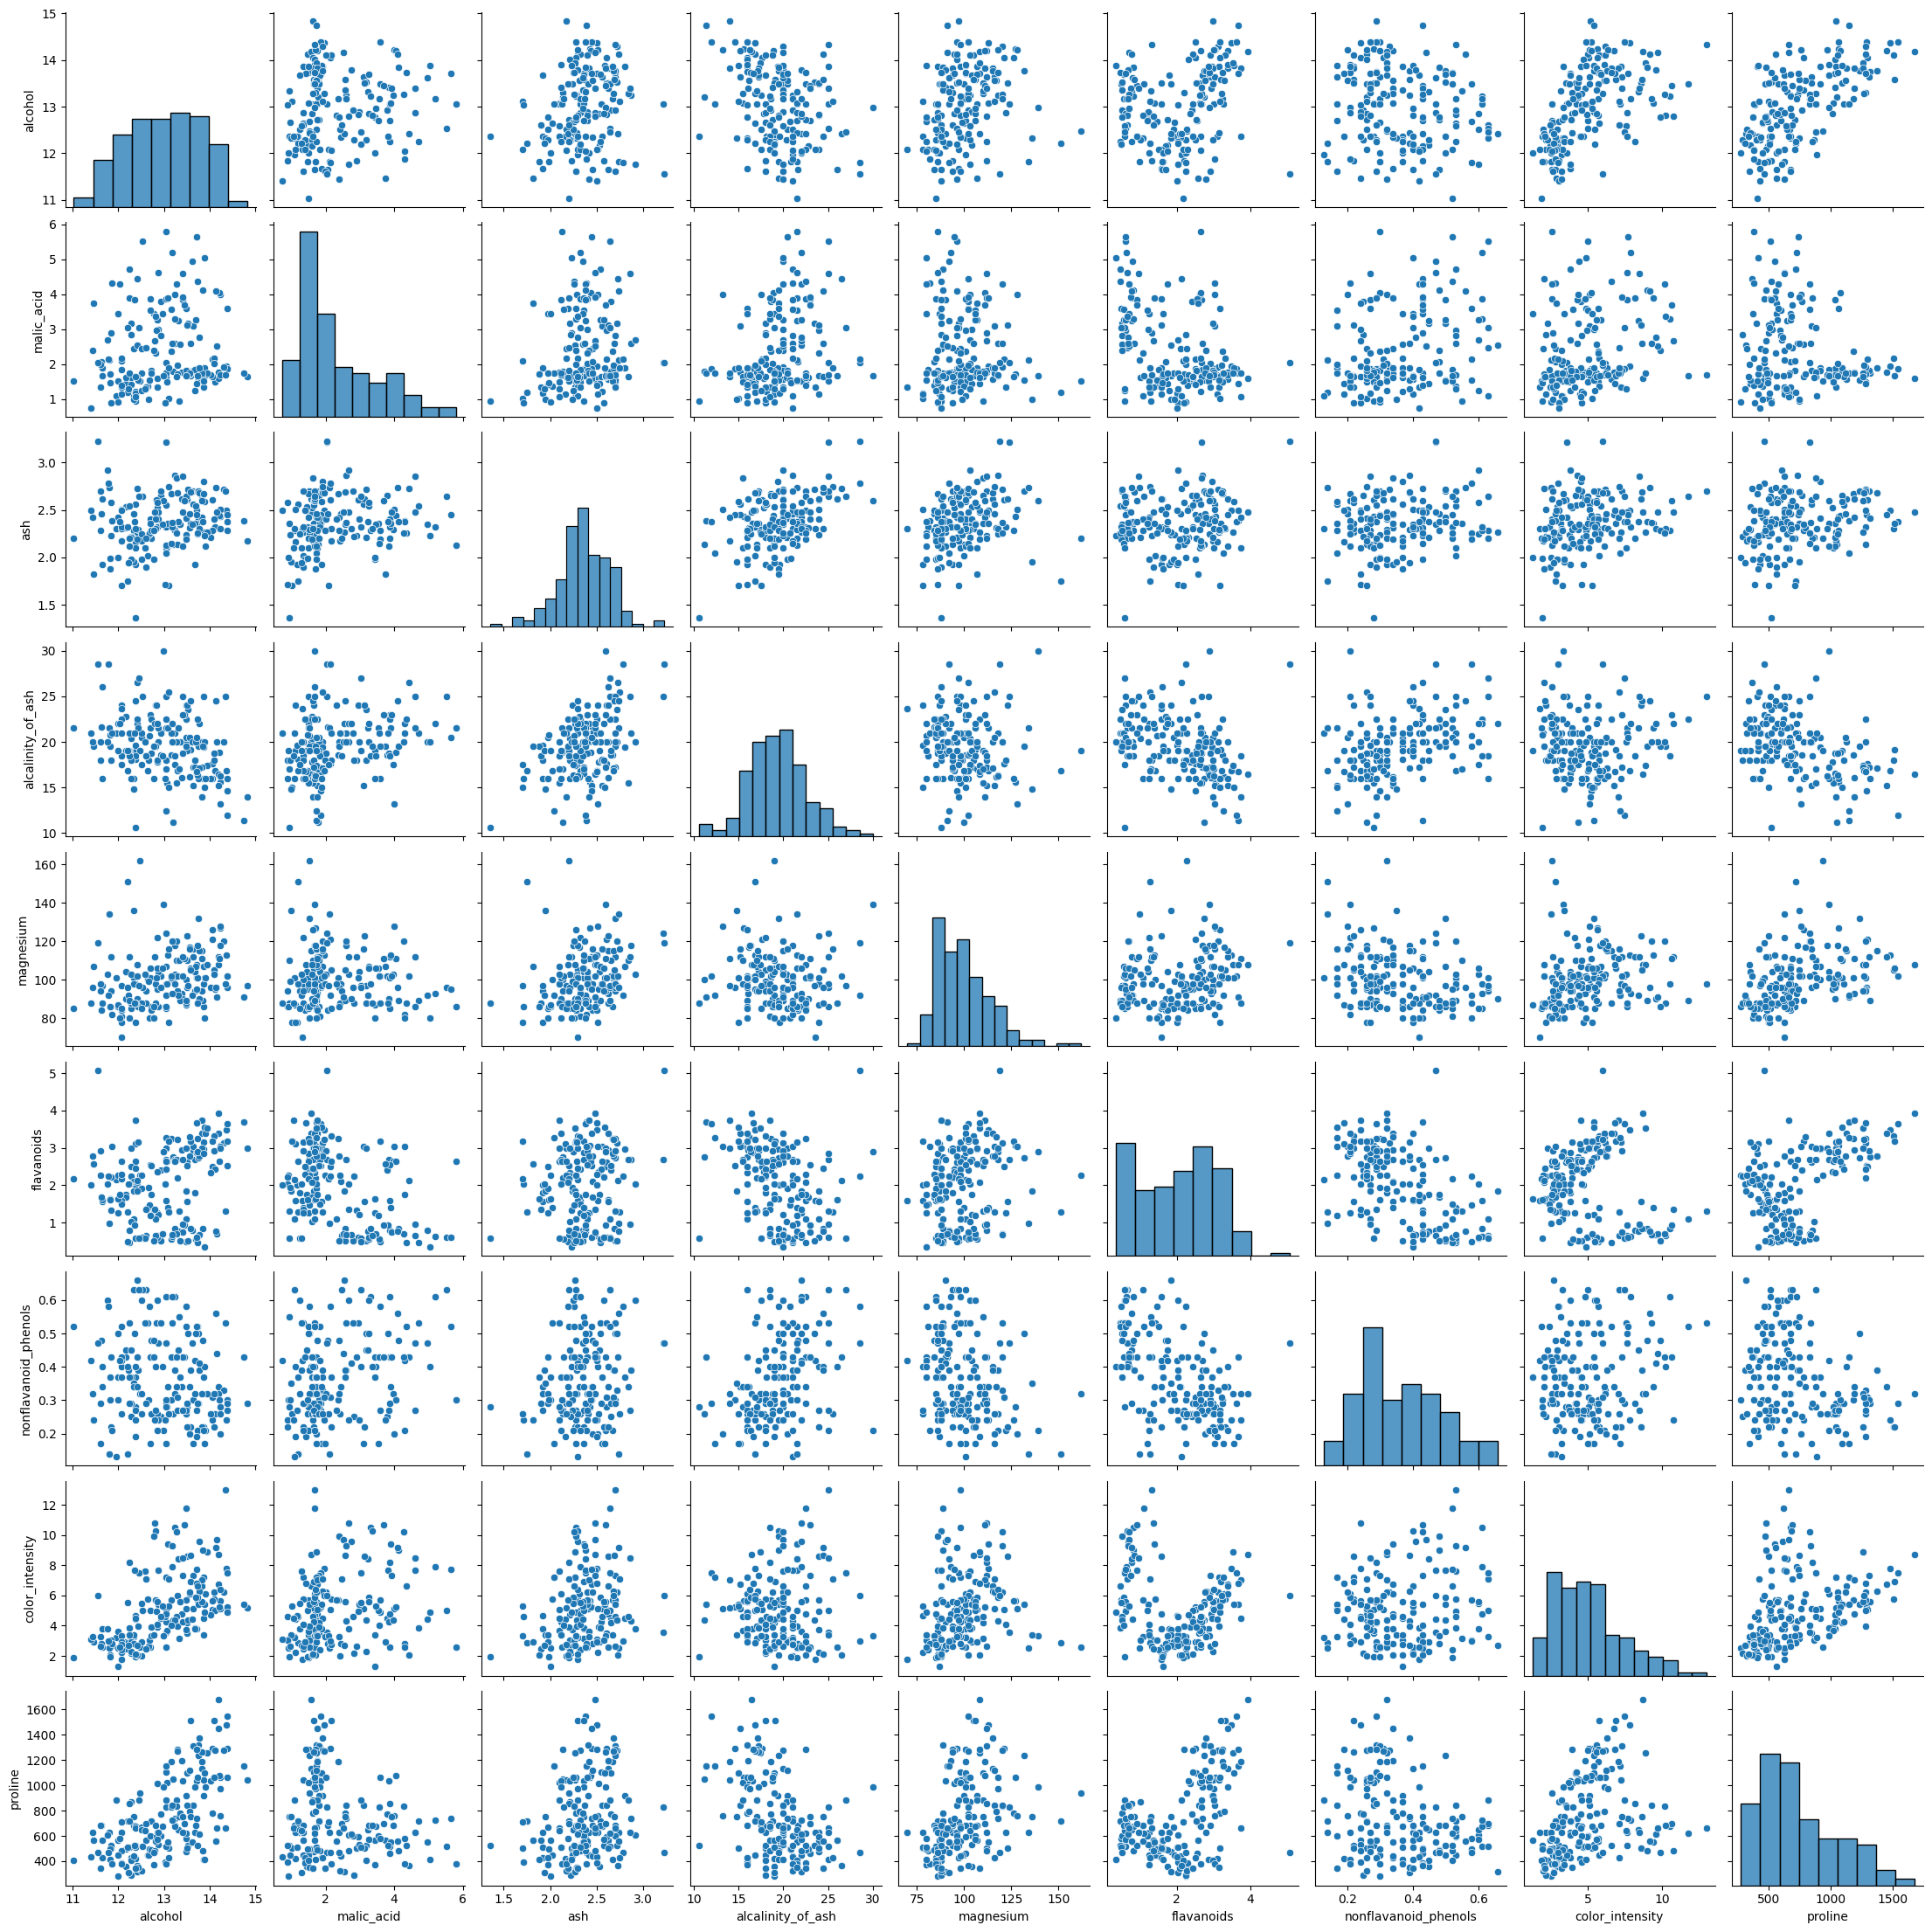

In [ ]:
sns.pairplot(X)

 Теперь ситуация с признаками гораздо лучше

Скалинг признаков:

In [ ]:
y = data_wine.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.to_numpy())
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X = X_scaled
y = df_wine['target']
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

**1) KNN**

In [ ]:
parameters = {'n_neighbors': [3, 5, 7, 10, 12, 15, 20, 25, 30, 35, 50], 'weights': ['distance', 'uniform']}
neigh = KNeighborsClassifier()
clf = GridSearchCV(neigh, parameters, scoring=['balanced_accuracy', 'f1_macro'], refit='f1_macro', cv=15)
clf.fit(X, y)
clf.best_estimator_, clf.best_score_

(KNeighborsClassifier(n_neighbors=10, weights='distance'), 0.9715504248837583)

KNN хорошо работает на этом наборе данных, так как данные не сильно разбросаны, что видно из графиков. Количество соседей равное 10 самое лучшее, что логично, потому что оно не слишком большое (примерно четверть от класса с наименьшим количеством, и не слишком маленькое, чтобы лучше анализировать объекты, которые находятся "на границах")

**2) SVM**

In [ ]:
parameters = {'C': [0.01, 0.1, 1, 2, 3, 4, 10, 100, 1000], 'gamma': ['scale', 0.1, 0.5, 0.7, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid', 'poly'], 'coef0': [0, 1, 10, 100, 1000]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring=['balanced_accuracy', 'f1_macro'], refit='f1_macro', cv=15)
clf.fit(X, y)

GridSearchCV(cv=15, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 2, 3, 4, 10, 100, 1000],
                         'coef0': [0, 1, 10, 100, 1000],
                         'gamma': ['scale', 0.1, 0.5, 0.7, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             refit='f1_macro', scoring=['balanced_accuracy', 'f1_macro'])

In [ ]:
clf.best_estimator_, clf.best_score_

(SVC(C=4, coef0=0, gamma=0.01, kernel='sigmoid'), 0.9878916145582812)

SVM справился с данной задачей лучше, чем KNN, что было ожидаемо, так как это более продвинутый алгоритм. Параметр kernel нелинейный, чтобы лучше классифицировать значения на границах, скорее всего за счет этих значений svm работает лучше, чем knn.

**3) Метод парзеновского окна**

Реализиуем свой классификатор на основе [Окна Парзена](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9F%D0%B0%D1%80%D0%B7%D0%B5%D0%BD%D0%BE%D0%B2%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%BA%D0%BD%D0%B0_%28%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%29):

In [ ]:
class KernelFunctions:
  @staticmethod
  def epanechnikov(u):
    if abs(u) <= 1:
      return 3/4*(1-u**2)
    else:
      return 0

  @staticmethod
  def gaussian(u):
    return 1/(np.sqrt(2*np.pi))*np.exp(-1/2*u**2)

  @staticmethod
  def rectangular(u):
    if abs(u) <= 1:
      return 1/2
    else:
      return 0

  @staticmethod
  def linear(u):
    if abs(u) <= 1:
      return 1 - abs(u)
    else:
      return 0

  @staticmethod
  def cosine(u):
    if abs(u) <= 1:
      return np.pi/4*np.cos(np.pi/2*u)
    else:
      return 0

  @staticmethod
  def quartic(u):
    if abs(u) <= 1:
      return 15/16*(1-u**2)**2
    else:
      return 0

  @staticmethod
  def tricube(u):
    if abs(u) <= 1:
      return 70/81*(1-abs(u)**3)**3
    else:
      return 0

In [ ]:
class ParzenWindowClassifier:
  def __init__(self, h=1, kernel_function='gaussian'):
    self.kernel_fucntions = {
        'epanechnikov': KernelFunctions.epanechnikov,
        'gaussian': KernelFunctions.gaussian,
        'rectangular': KernelFunctions.rectangular,
        'linear': KernelFunctions.linear,
        'cosine': KernelFunctions.cosine,
        'quartic': KernelFunctions.quartic,
        'tricube': KernelFunctions.tricube
    }
    self.X_train = None
    self.y_train = None
    self.classes = None
    self.kernel_function = self.kernel_fucntions[kernel_function]
    self.h = h

  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train
    self.classes = y_train.unique()

  def parzen_density_estimation(self, x, y):
    p = 0
    for x_tr, y_tr in zip(self.X_train.values, self.y_train.values):
      dist = np.linalg.norm(x_tr - x)
      p += (y==y_tr)*self.kernel_function(dist/self.h)
    return p

  def predict(self, X):
    pred_y = pd.Series(data=np.zeros(X.shape[0]), index=X.index)
    for i in X.index:
      values = pd.Series(data=np.zeros(len(self.classes)), index=self.classes)
      for y in self.classes:
        values[y] += self.parzen_density_estimation(X.loc[i].values, y)
      pred_y[i] = values.argmax()
    return pred_y

# признаки подобраны по важности с помощью рандом форест и линейной регрессии
X = X_scaled[['flavanoids', 'alcohol', 'proline']]
y = df_wine['target']
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)


pwc = ParzenWindowClassifier()

score_max = 0
param_max = {'h': None, 'kernel_function': None}
accuracy_max = 0
f1_max = 0

for h in [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
  for kernel_function in ['epanechnikov', 'gaussian', 'rectangular', 'linear', 'cosine', 'quartic', 'tricube']:
    pwc = ParzenWindowClassifier(h, kernel_function)
    pwc.fit(X_train, y_train)
    pred_y = pwc.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y, average='macro')
    score_mean = (accuracy + f1)/2
    if score_mean > score_max:
      score_max = score_mean
      param_max['h'] = h
      param_max['kernel_function'] = kernel_function
      accuracy_max = accuracy
      f1_max = f1
    print("h: {}, func: {}, balanced_accuracy: {}, f1_score: {}".format(h, kernel_function, accuracy, f1))

h: 0.1, func: epanechnikov, balanced_accuracy: 0.3333333333333333, f1_score: 0.17316017316017315
h: 0.1, func: gaussian, balanced_accuracy: 0.39166666666666666, f1_score: 0.3842105263157895
h: 0.1, func: rectangular, balanced_accuracy: 0.3333333333333333, f1_score: 0.17316017316017315
h: 0.1, func: linear, balanced_accuracy: 0.3333333333333333, f1_score: 0.17316017316017315
h: 0.1, func: cosine, balanced_accuracy: 0.3333333333333333, f1_score: 0.17316017316017315
h: 0.1, func: quartic, balanced_accuracy: 0.3333333333333333, f1_score: 0.17316017316017315
h: 0.1, func: tricube, balanced_accuracy: 0.3333333333333333, f1_score: 0.17316017316017315
h: 0.5, func: epanechnikov, balanced_accuracy: 0.36944444444444446, f1_score: 0.32143382311355434
h: 0.5, func: gaussian, balanced_accuracy: 0.375, f1_score: 0.38095238095238093
h: 0.5, func: rectangular, balanced_accuracy: 0.3833333333333333, f1_score: 0.33870931078377886
h: 0.5, func: linear, balanced_accuracy: 0.36944444444444446, f1_score: 0.

In [ ]:
print("accuracy_max: {}, f1_max: {}, h: {}, func: {}".format(accuracy_max, f1_max, param_max['h'], param_max['kernel_function']))

accuracy_max: 0.65, f1_max: 0.5066045066045066, h: 6, func: quartic


Метод парезеневского окна показал плохие результаты по сравнению с svm и knn, скорее всего это связано с тем, что для данной задачи трех признаков слишком мало для предсказывания, а при большем количестве признаков алгоритм начинат выдавать результаты намного хуже, чем при трех признаках.

**4) Перцептрон**

In [ ]:
X = df_wine.drop('target', axis=1)
X = X.drop(['od280/od315_of_diluted_wines', 'total_phenols', 'proanthocyanins', 'hue'], axis=1)
y = data_wine.target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.to_numpy())
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X = X_scaled
y = df_wine['target']

In [ ]:
parameters = {'penalty': [None, 'l1', 'l2', 'elasticnet'], 'class_weight': [None, 'balanced'],
              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

perceptron = Perceptron()
clf = GridSearchCV(perceptron, parameters, scoring=['balanced_accuracy', 'f1_macro'], refit='f1_macro', cv=15)
clf.fit(X, y)
clf.best_estimator_, clf.best_score_

(Perceptron(alpha=0.001, class_weight='balanced', l1_ratio=0.1,
            penalty='elasticnet'),
 0.9943562610229276)

Перцептрон показал результаты даже лучше, чем svm. При обучении учитывается дисбаланс классов и также производится l1 регуляризация с небольшим коэффициентом, чтобы не было переобучения.

**Задача 2 (40 баллов)**

Построить модели машинного обучения для задачи регрессии: а именно: линейная регрессия, метод Надарая-Ватсона, персептрон.

По датасету вновь ограничений никаких нет, можно взять, например:

Servo Data Set : https://archive.ics.uci.edu/ml/datasets/Servo

Forest Fires Data Set : https://archive.ics.uci.edu/ml/datasets/Forest+Fires

По требованиям к оформлению и построению модели и результатов все так же, как в первом задании.

**Подготовка даныых**

Скачаем данные

In [ ]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
download_url("https://archive.ics.uci.edu/static/public/9/auto+mpg.zip", "auto+mpg.zip")

In [ ]:
with ZipFile("auto+mpg.zip", "r") as myzip:
    myzip.extractall()

In [ ]:
with open("auto-mpg.data", "r") as f, open("new_mpg.csv", "w+") as f_new:
  for line in f:
    line = line.split('"')[0]
    new_line = ",".join(line.split()) + "\n"
    f_new.write(new_line)

In [ ]:
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight",
           "acceleration", "model_year", "origin"]

data = pd.read_csv("new_mpg.csv", names=columns)
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model_year        int64
origin            int64
dtype: object

'horsepower' имеет тип object, провреим уникальные значения

In [ ]:
data.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

удалим пропущенные значения и преобразуем строки к float

In [ ]:
del_index = data[data.horsepower == "?"].index
data = data.drop(del_index)
data['horsepower'] = pd.to_numeric(data['horsepower'])

In [ ]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
dtype: object

<Axes: >

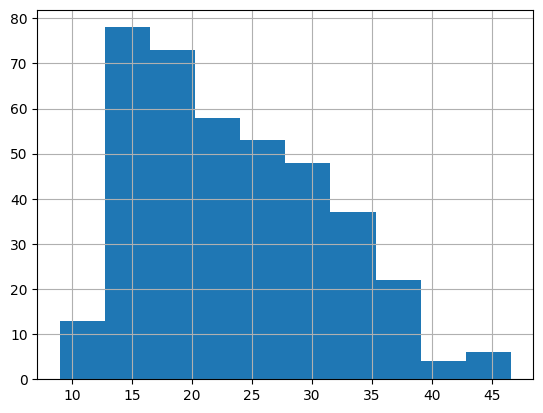

In [ ]:
y = data['mpg']
X = data.drop('mpg', axis=1)
y.hist()

Преобразуме год создания

In [ ]:
X['model_year'].value_counts()

73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: model_year, dtype: int64

In [ ]:
X['model_year'] = X['model_year'].apply(lambda x: x - 69)
X['model_year'].value_counts()

4     40
9     36
7     34
6     30
13    30
1     29
10    29
3     28
8     28
12    28
2     27
11    27
5     26
Name: model_year, dtype: int64

Скалинг данных:

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.to_numpy())
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X = X_scaled
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

In [ ]:
X.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,3.920000e+02,392.000000,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02
mean,-7.250436e-17,0.000000,1.812609e-17,-1.812609e-17,-1.812609e-17,1.450087e-16,6.344132e-17
std,1.001278e+00,1.001278,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00,1.001278e+00
min,-1.451004e+00,-1.209563,-1.520975e+00,-1.608575e+00,-2.736983e+00,-1.625315e+00,-7.166410e-01
25%,-8.640136e-01,-0.855532,-7.665929e-01,-8.868535e-01,-6.410551e-01,-8.098841e-01,-7.166410e-01
50%,-8.640136e-01,-0.415384,-2.853488e-01,-2.052109e-01,-1.499869e-02,5.547151e-03,-7.166410e-01
75%,1.483947e+00,0.778276,5.600800e-01,7.510927e-01,5.384714e-01,8.209784e-01,5.263824e-01
max,1.483947e+00,2.493416,3.265452e+00,2.549061e+00,3.360262e+00,1.636410e+00,1.769406e+00


In [ ]:
y.mean()

23.445918367346938

**1) Линейная регрессия**

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

(10.509528553833352, 2.5018813462212304)

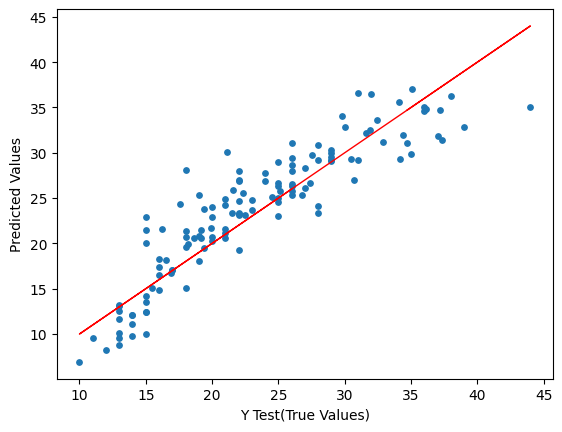

In [ ]:
plt.scatter(y_test,y_pred,s=15)
plt.xlabel('Y Test(True Values)')
plt.ylabel('Predicted Values')
plt.plot(y_test, y_test, color='red', lw=1)
plt.show()

Линейная регрессия показала неплохие результаты, средняя абсолютная ошибка равняется 10% от среднего значения целевого значения. Это значит, что данные линейно кореллируют с целевым значением.

**2) метод Надарая-Ватсона**

Реализуем регрессор на основе метода [Надарая-Ватсона](http://www.machinelearning.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%9D%D0%B0%D0%B4%D0%B0%D1%80%D0%B0%D1%8F-%D0%92%D0%B0%D1%82%D1%81%D0%BE%D0%BD%D0%B0):

In [ ]:
class NWRegressor:
  def __init__(self, h=1, kernel_function='gaussian'):
    self.kernel_functions = {
          'epanechnikov': KernelFunctions.epanechnikov,
          'gaussian': KernelFunctions.gaussian,
          'rectangular': KernelFunctions.rectangular,
          'linear': KernelFunctions.linear,
          'cosine': KernelFunctions.cosine,
          'quartic': KernelFunctions.quartic,
          'tricube': KernelFunctions.tricube
    }
    self.h = h
    self.kernel_function = self.kernel_functions[kernel_function]
    self.X_train = None
    self.y_train = None

  def fit(self, X_train: np.array, y_train: np.array):
    self.X_train = X_train
    self.y_train = y_train

  def predict(self, X: pd.DataFrame):
    y_pred = pd.Series(data=np.zeros(X.shape[0]), index=X.index)
    for i in X.index:
      num = 0
      den = 0
      for x_tr, y_tr in zip(self.X_train, self.y_train):
        dist = np.linalg.norm(x_tr - X.loc[i])
        num += self.kernel_function(dist/self.h)*y_tr
        den += self.kernel_function(dist/self.h)
      y_pred[i] = num/den
    return y_pred

In [ ]:
score_min = 1000
param_min = {'h': None, 'kernel_function': None}
mse_min = 1000
mae_min = 1000
for h in [1.5, 2, 2.5, 3, 4, 5, 6]:
  for kernel_function in ['epanechnikov', 'gaussian', 'rectangular', 'linear', 'cosine', 'quartic', 'tricube']:
    nwr = NWRegressor(h, kernel_function)
    nwr.fit(X_train.values, y_train.values)
    pred_y = nwr.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)
    mae = mean_absolute_error(y_test, pred_y)
    score_mean = (mse + mae)/2
    if score_mean < score_min:
      score_min = score_mean
      param_min['h'] = h
      param_min['kernel_function'] = kernel_function
      mse_min = mse
      mae_min = mae
    print("h: {}, func: {}, mse: {}, mae: {}".format(h, kernel_function, mse, mae))

h: 1.5, func: epanechnikov, mse: 6.74115473412881, mae: 2.067332662629905
h: 1.5, func: gaussian, mse: 14.411410630094451, mae: 2.926934477781711
h: 1.5, func: rectangular, mse: 8.10364168464813, mae: 2.278379859490258
h: 1.5, func: linear, mse: 6.580559175454832, mae: 2.0437362680116515
h: 1.5, func: cosine, mse: 6.680114658573629, mae: 2.05816836902527
h: 1.5, func: quartic, mse: 6.490164291775092, mae: 2.0043769219759033
h: 1.5, func: tricube, mse: 6.570301091397993, mae: 2.0059489412285925
h: 2, func: epanechnikov, mse: 8.629663966602147, mae: 2.379473577149748
h: 2, func: gaussian, mse: 18.321958990556496, mae: 3.3715751350688152
h: 2, func: rectangular, mse: 10.663618956548023, mae: 2.604279403167242
h: 2, func: linear, mse: 8.24725874105949, mae: 2.325963670690495
h: 2, func: cosine, mse: 8.471211633852894, mae: 2.3581371817849885
h: 2, func: quartic, mse: 7.58240272025521, mae: 2.224861070601565
h: 2, func: tricube, mse: 7.457730473509956, mae: 2.2020627890104048
h: 2.5, func: 

In [ ]:
print("mse_min: {}, mae_min: {}, h: {}, func: {}".format(mse_min, mae_min, param_min['h'], param_min['kernel_function']))

mse_min: 6.490164291775092, mae_min: 2.0043769219759033, h: 1.5, func: quartic


In [ ]:
nwr = NWRegressor(1.5, 'quartic')
nwr.fit(X_train.values, y_train.values)
pred_y = nwr.predict(X_test)
mean_squared_error(y_test, pred_y), mean_absolute_error(y_test, pred_y)

(6.490164291775092, 2.0043769219759033)

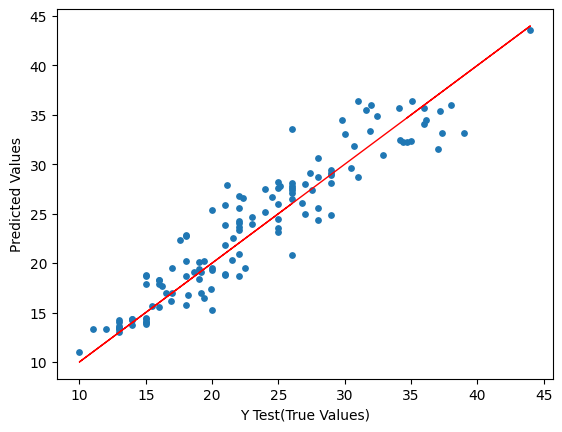

In [ ]:
plt.scatter(y_test, pred_y, s=15)
plt.xlabel('Y Test(True Values)')
plt.ylabel('Predicted Values')
plt.plot(y_test, y_test, color='red', lw=1)
plt.show()

Регрессор на основе формулы Надарая-Ватсона отработал лучше, чем линейная регрессия за счет функций ядра, которые позволяет модели приобрести нелинейный характер.

**3) Перцептрон**

In [ ]:
perc = MLPRegressor(max_iter=2000)
perc.fit(X_train, y_train)
pred_y = perc.predict(X_test)
mean_squared_error(y_test, pred_y), mean_absolute_error(y_test, pred_y)

(7.652667198024861, 1.9413104807578725)

In [ ]:
parameters = {'hidden_layer_sizes': [300],
              'activation': ['identity', 'logistic', 'relu'],
              'max_iter' : [2000],
              'alpha': [0.01, 0.1, 1, 10, 100],
              'n_iter_no_change': [5],
              'solver': ['sgd', 'adam']
              }

perceptron = MLPRegressor()
clf = GridSearchCV(perceptron, parameters,scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], refit='neg_mean_squared_error')
clf.fit(X, y)
clf.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

MLPRegressor(alpha=10, hidden_layer_sizes=300, max_iter=2000,
             n_iter_no_change=5)

In [ ]:
clf.best_score_

-8.764527916765903

In [ ]:
ml = MLPRegressor(hidden_layer_sizes=300, max_iter=2000, n_iter_no_change=5, alpha=10)
ml.fit(X_train, y_train)
y_pred = ml.predict(X_test)
mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

(7.21336607649465, 1.9082673305093485)

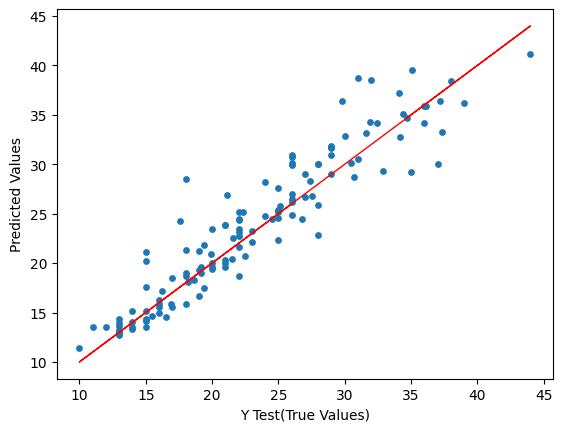

In [ ]:
plt.scatter(y_test,y_pred,s=15)
plt.xlabel('Y Test(True Values)')
plt.ylabel('Predicted Values')
plt.plot(y_test, y_test, color='red', lw=1)
plt.show()

Чтобы решить данную задачу регрессии с помощью персептрона нужно много времени, так как за малое количество итераций не достигается нужное значение, тем не менее нейронаая сеть показала результаты лучше, чем предшествующие модели.